# Analiza serij na spletnem portalu [MAL](https://myanimelist.net/topanime.php)
Projektna naloga pri predmetu Programiranje 1

## 0. Priprava podatkov

Preden začnemo, moramo uvoziti vnaprej pripravljene podatke. V ta namen uporabimo knjižnico pandas in vnesemo podatke v tabele.

In [1]:
import pandas as pd
import os

# izberemo interaktivni stil risanja
%matplotlib inline

# spremenimo velikost figur
import matplotlib as plt
plt.rcParams['figure.figsize'] = (10, 5)

pd.set_option('display.max_rows', 20)

# naložimo razpredelnice, s katero bomo delali
pot_do_serij = os.path.join('data', 'serije.csv')
pot_do_licensorjev = os.path.join('data', 'licensorji.csv')
pot_do_producerjev = os.path.join('data', 'producerji.csv')
pot_do_studijev = os.path.join('data', 'studiji.csv')
pot_do_zanrov = os.path.join('data', 'žanri.csv')


serije = pd.read_csv(pot_do_serij)
licensorji = pd.read_csv(pot_do_licensorjev)
producerji = pd.read_csv(pot_do_producerjev)
studiji = pd.read_csv(pot_do_studijev)
zanri = pd.read_csv(pot_do_zanrov)

Tukaj še malo očisitmo podatke, saj nam manjkajoča polja pri popularnosti in število glasov gredo samo v napoto.

In [2]:
serije = serije[
        serije.popularity.notnull() &  serije.votes.notnull()
    ].astype(
        {'popularity': 'int64', 'votes': 'int64'}
    ).sort_values('popularity')

Nato razcepimo čas premiere na leto in sezono, saj bo z razcepljenima podatkoma kasnejša obravnava lažja. Poleg tega bomo tudi kasneje obravnavali vsakega izmed njiju posebej.

In [3]:
def add_season_year(df, premiered_series):
    def get_year(s):
        if type(s) == str:
            return int(s.split()[1])
        else:
            return float('NaN')
    
    def get_season(s):
        if type(s) == str:
            return s.split()[0]
        else:
            return float('NaN')
        
    leta = premiered_series.apply(get_year)
    sezone = premiered_series.apply(get_season)
    
    df['leto'] = leta
    df['sezona'] = sezone


add_season_year(serije, serije.premiered)

Sedaj si oglejmo, katere podatke smo zajeli. Začnimo z glavno tabelo, tabelo serij.
Kot vidimo, so zajeta naslednja polja:
* naslov
* vrsta serije
* število epizod
* status predvajanja
* čas premiere
* vir originalnega materiala
* trajanje posamezne epizode
* primernost vsebine
* ocena uporabnikov
* število glasov
* popularnost glede na število uporabnikov, ki so si serijo ogledali
* leto izdaje
* sezona izdaje

In [4]:
serije

,title,series_type,episodes,status,premiered,source,duration,rating,score,votes,popularity,leto,sezona
0,Death Note,TV,37.0,Finished Airing,Fall 2006,Manga,23.0,R - 17+ (violence & profanity),8.62,1572817,1,2006.0,Fall
1,Shingeki no Kyojin,TV,25.0,Finished Airing,Spring 2013,Manga,24.0,R - 17+ (violence & profanity),8.45,1505350,2,2013.0,Spring
2,Sword Art Online,TV,25.0,Finished Airing,Summer 2012,Light novel,23.0,PG-13 - Teens 13 or older,7.29,1393564,3,2012.0,Summer
3,Fullmetal Alchemist: Brotherhood,TV,64.0,Finished Airing,Spring 2009,Manga,24.0,R - 17+ (violence & profanity),9.22,1220469,4,2009.0,Spring
4,One Punch Man,TV,12.0,Finished Airing,Fall 2015,Web manga,24.0,R - 17+ (violence & profanity),8.60,1283682,5,2015.0,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9518,Kyokujitsu no Kantai,OVA,15.0,Finished Airing,NaN,Unknown,30.0,PG-13 - Teens 13 or older,6.39,113,9995,NaN,NaN
9517,Youkai Watch!,TV,36.0,Finished Airing,Spring 2019,Game,24.0,G - All Ages,6.19,236,9996,2019.0,Spring
9519,Yonimo Osoroshii Grimm Douwa,OVA,3.0,Finished Airing,NaN,Other,20.0,R - 17+ (violence & profanity),6.06,160,9997,NaN,NaN
9524,White Fantasy,Special,1.0,Finished Airing,NaN,Unknown,2.0,G - All Ages,5.71,506,9998,NaN,NaN


V tabeli licensorjev so seveda shranjeni licensorji. To so podjetja, ki jim pripadajo pravice do serij. Niso pa to nujno podjetja, ki so proizvedle serijo, ampak jo samo izdajajo. Torej so nekako kot izdajatelji, ki naročajo avtorjem, kaj želijo imeti narejeno.

In [5]:
licensorji

,title,licensor
0,Death Note,Viz Media
1,Shingeki no Kyojin,Funimation
2,Sword Art Online,Aniplex of America
3,Fullmetal Alchemist: Brotherhood,Funimation
4,Fullmetal Alchemist: Brotherhood,Aniplex of America
...,...,...
4558,Ai no Utagoe wo Kikasete,Funimation
4559,Gall Force 3: Stardust War,Central Park Media
4560,Cheer Danshi!! Specials,Funimation
4561,Machikado Mazoku Mini,Sentai Filmworks


Producerji imajo nadzor nad kreacijo serije. Odločajo se, kateri studio bo naredil animacije, katere glasovne igralce bodo pozvali k igranju, katere dele originalnega materiala bodo uporabili. Torej imajo v nadzoru širšo sliko proizvodnje.

In [6]:
producerji

,title,producer
0,Death Note,VAP
1,Death Note,Konami
2,Death Note,Ashi Production
3,Death Note,Nippon Television Network
4,Death Note,Shueisha
...,...,...
16184,Last Exile: Doyou no Asa,I was a Ballerina
16185,Wan Sheng Jie 2,Tencent Penguin Pictures
16186,Yousei Ou,Kadokawa Shoten
16187,Osomatsu-san: Haru no Zenkoku Dai Senbatsu Jou...,Avex Pictures


Studiji so odgovorni za samo animacijo in proizvodnjo epizod kot celote. Čeprav so bolj proti dnu same hierarhije, imajo ravno oni največji vpliv na izgled serije, saj so odgovorni za vizualni del.

In [7]:
studiji

,title,studio
0,Death Note,Madhouse
1,Shingeki no Kyojin,Wit Studio
2,Sword Art Online,A-1 Pictures
3,Fullmetal Alchemist: Brotherhood,Bones
4,One Punch Man,Madhouse
...,...,...
8687,You Yao,Shenying Animation
8688,Yousei Ou,Madhouse
8689,Osomatsu-san: Haru no Zenkoku Dai Senbatsu Jou...,Studio Pierrot
8690,WIXOSS Diva(A)Live,J.C.Staff


Na koncu pa imamo še tabelo žanrov, kjer je za vsako serijo shranjen širši žanr, v katerega spada.

In [8]:
zanri

,title,genre
0,Death Note,Mystery
1,Death Note,Police
2,Death Note,Psychological
3,Death Note,Supernatural
4,Death Note,Thriller
...,...,...
34004,Carol,Magic
34005,Carol,Shoujo
34006,WIXOSS Diva(A)Live,Game
34007,WIXOSS Diva(A)Live,Psychological


## 1. Vpliv posamičnih elementov na popularnost in oceno

### 1.1 Čas premiere

Standardni časi premier so razdeljeni na 4 letne čase. V navadi je namreč, da se leto razdeli na 4 časovna obdobja po 12 tednov in v vsakem tednu izide nova epizoda. Zaradi tega so popularne 12 in 24 epizod dolge serije in studiji so primorani se močno držati teh rokov. V nasprotnem primeru se morajo višji v hierarhiji odločiti ali končati serijo na slabem mestu, ali pa zakupiti mesto za predajanje v naslednji sezoni.

In [9]:
serije.groupby('sezona').mean()[['score', 'votes', 'popularity']]

,score,votes,popularity
sezona,,,
Fall,7.024652,59136.686654,3428.080271
Spring,7.006236,56812.445455,3735.605455
Summer,6.921765,68194.583333,2806.037582
Winter,6.926926,56138.025000,3480.489706


Opazimo, da je poletni čas rahla anomalija glede tako na popularnost, kot na število glasov. Pričakovali bi, da med sezonami ne bi bilo velikih razlik, saj lahko dobre serije izidejo kadarkoli. Najverjetneje gre za dejstvo, da imajo ljudje med poletjem preprosto več prostega časa. Tu še posebej pride do izraza razporeditev populacije glede na starost. Namreč otroci in najstniki ne samo da imajo poleti čas zaradi počitnic, ampak so tudi največji delež populacije, ki uporablja internet. Kombinacija teh dveh dejstev pripomore, da je poleti največ aktivnosti.

<AxesSubplot:xlabel='sezona'>

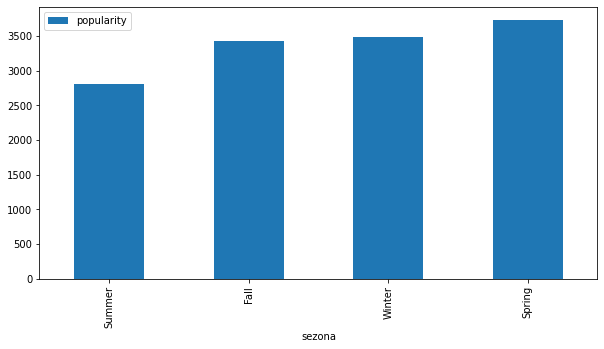

In [10]:
serije.groupby('sezona').mean().sort_values('popularity').plot.bar(y='popularity')

<AxesSubplot:xlabel='sezona'>

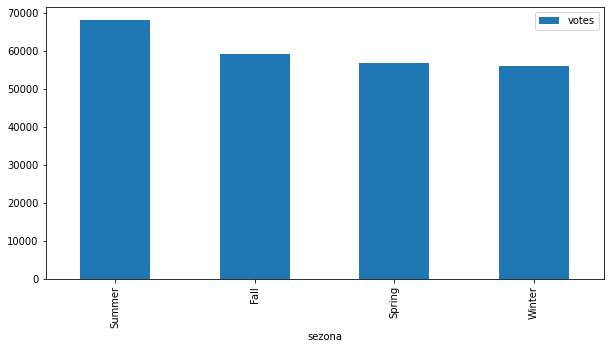

In [11]:
serije.groupby('sezona').mean().sort_values('votes', ascending=False).plot.bar(y='votes')

Dejstvo, da so ocene serij bolj ali manj enake ne glede na čas premiere, toliko bolj potrdi domnevo, da gre pri povišani aktivnosti preko poletja res za večjo mero prostega časa pri uporabnikih. Namreč ni opazne razlike v kvaliteti serij, ki bi konstanto spodbujevale pogovore, slabe ali dobre.

<AxesSubplot:xlabel='sezona'>

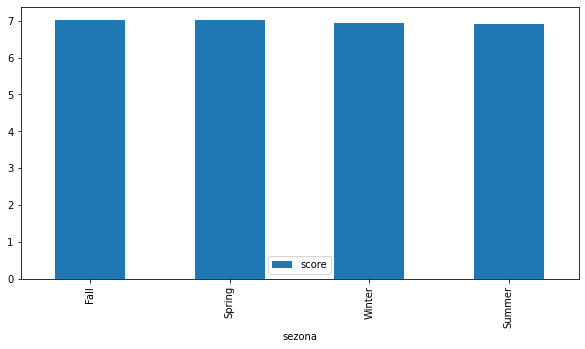

In [12]:
serije.groupby('sezona').mean().sort_values('score', ascending=False).plot.bar(y='score')

Nato si poglejmo še leto premiere. Pričakovano je, da se bo z leti popularnost zmanjševala zaradi naslednjih razlogov:
* novejša tehnologijo omogoča več kreativnosti in bolj osupljive možnosti animacije
* dostop do starih serij je veliko težji
* oboževalci starih serij so starejši in zato v delu populacije, ki interneta ne uporablja toliko kot mlajši

In [13]:
serije.groupby('leto').mean()

,episodes,duration,score,votes,popularity
leto,,,,,
1963.0,115.000000,25.333333,6.393333,991.666667,7667.333333
1965.0,52.000000,25.000000,6.580000,1910.000000,5928.000000
1966.0,41.000000,22.500000,6.500000,497.000000,8258.000000
1967.0,63.800000,25.200000,6.496000,1525.600000,7588.200000
1968.0,70.200000,24.800000,6.594000,530.000000,8326.200000
...,...,...,...,...,...
2016.0,18.023364,18.816901,6.798372,76209.544186,2538.483721
2017.0,15.158974,19.416244,6.748731,68423.700508,2571.284264
2018.0,17.111628,20.055814,6.881581,57612.823256,2677.879070


In res, novejše serije so bolj popularne od starejših. Zanimiv pa je padec popularnosti v zadnjih desetih letih. En možen faktor je, da je pri malo starejših serijah poteklo že dovolj časa, da si jo lahko uporabniki ogledajo. Pri novejših serijah, predvsem s povečanjem popularnosti ogleda preko interneta, ni dovolj časa za ogled vseh novo izdanih serij.

<AxesSubplot:xlabel='leto'>

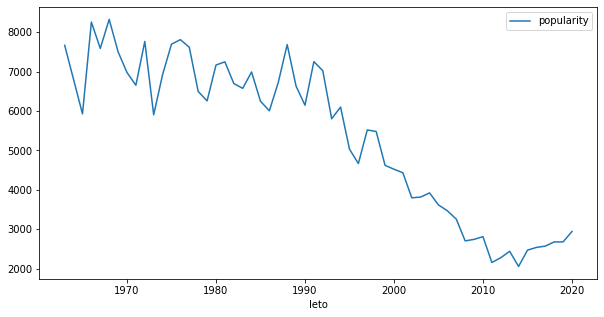

In [14]:
serije.groupby('leto').mean().plot(y='popularity')

Drug prispevajoč faktor je morda padec kvalitete v primerjavi z malo starejšimi serijami. Opazimo lahko višje ocene za serije v okolici leta 2010 v primerjavi s tistimi okoli leta 2000 in sedajšnimi. Z rastočo priljubljenostjo tega vira zabave, se povečuje število izdanih serij. Precej verjetno je, da je kvaliteta objektivno slabša zaradi večjega pritiska na studije, da proizvedejo čim več serij.

<AxesSubplot:xlabel='leto'>

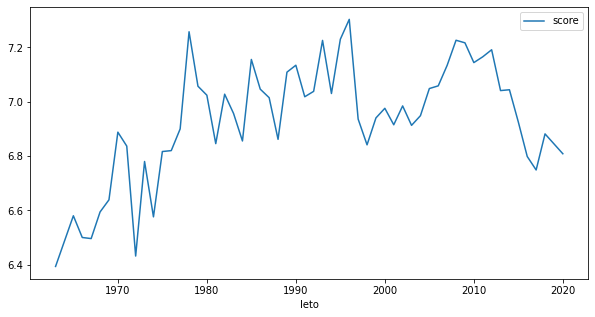

In [15]:
serije.groupby('leto').mean().plot(y='score')

## 1.2 Vir originalnega materiala

Velik del serij je animacija predhodnega materiala. Prednost je predvsem v tem, da je za originalne serije potrebno precej več vloženega časa, truda, planiranja, in kljub temu je možnost uspeha morda celo manjša. Namreč originalni material ima že privržence, ki so navdušeni nad pridobitvijo novega materiala v franšizi.

Zato so dobljeni podatki smiselni. Popularnost iger, manga serij in "lahkih novel" je na splošno veliko večja od knjig, radia in glasbenih del. In animirane serije to toliko bolj potrdijo, saj obstaja veliko večje zanimanje za popularne franšize.

In [16]:
serije.groupby('source').mean()

,episodes,duration,score,votes,popularity,leto
source,,,,,,
4-koma manga,10.597285,14.977064,6.844330,29798.450893,4050.343750,2013.104000
Book,25.170213,46.659574,6.897660,4865.936170,6351.702128,1991.821429
Card game,27.348837,21.866667,6.458261,10115.173913,5798.500000,2014.000000
Digital manga,7.916667,10.333333,5.965000,8972.250000,4964.000000,2016.428571
Game,12.693603,29.469697,6.495304,11909.208539,5203.059113,2011.763158
Light novel,8.750737,26.822995,7.092742,83815.004399,2375.412023,2012.298193
Manga,15.029450,30.297654,7.011150,39811.056023,4076.163212,2006.992181
Music,3.559322,11.474576,6.664237,11026.305085,6111.050847,2016.909091
Novel,14.028754,39.322476,6.998667,19872.139683,5232.257143,2003.117117


<AxesSubplot:xlabel='source'>

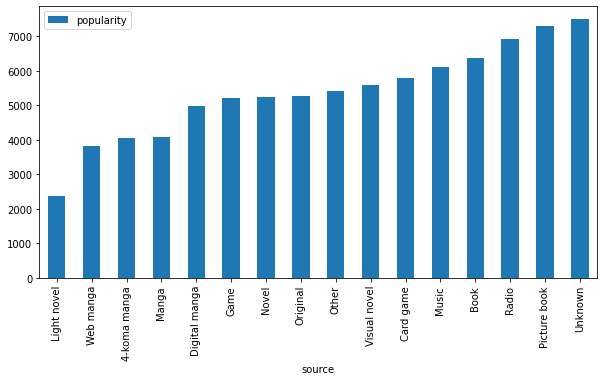

In [17]:
serije.groupby('source').mean().sort_values('popularity').plot.bar(y='popularity')

Ocene uporabnikov se tudi dokaj približno držijo popularnosti. Čeprav bi lahko prišlo do manjše kvalitete, saj bo serija uspešna že po zaslugi uspešnosti predhodnega materiala, se za res popularne franšize borijo res največja podjetja. In slaba adaptacija jim morda res ne uniči posla, vendar pa jim zagotovo prinese slab ugled s strani gledalcev serij. Poleg tega si lahko privoščijo bolj ambiciozne adaptacije, z boljšo glasbeno spremljavo, z boljšimi glasovni igralci in vse to skupaj privede v povprečju do večje kvalitete popularnih serij.

<AxesSubplot:xlabel='source'>

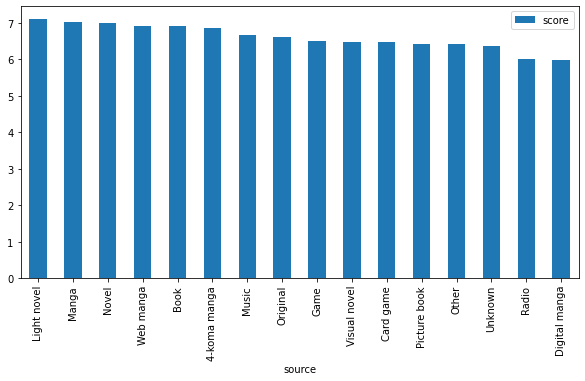

In [18]:
serije.groupby('source').mean().sort_values('score', ascending=False).plot.bar(y='score')

## 1.3 Čas trajanja epizode

Industrijski standard so postale približno 20-minutne epizode. Ta dolžina omogoča novo epizodo tedensko in ohrani določen nivo kvalitete. Zato je pričakovana večja popularnost pri 20-minutni dolžini epizode. 

Za druge dolžine epizod so odgovorne adaptacije drugih materialov, na primer par-minutni videospoti, eno-epizodne serije, kjer je njihova dolžina pač takšna, kot je. Za najdaljše dolžine epizod so odgovorni filmi. Za njihovo produkcijo gredo veliki stroški, je pa zato pričakovana visoka kvaliteta.

In [19]:
serije.groupby('duration').mean()

,episodes,score,votes,popularity,leto
duration,,,,,
1.0,7.139896,6.071675,2699.370558,6970.076142,2013.166667
2.0,7.393013,6.258996,5247.013100,6200.698690,2013.837209
3.0,8.901554,6.253692,6378.184615,5925.294872,2014.188976
4.0,5.650190,6.209053,5993.060606,6105.696970,2014.631579
5.0,8.863436,6.366184,5687.324561,6268.407895,2011.340426
...,...,...,...,...,...
156.0,1.000000,8.260000,43508.000000,1216.000000,NaN
160.0,1.000000,8.100000,13473.000000,2679.000000,NaN
161.0,1.000000,8.020000,9361.000000,3173.000000,NaN


In res, opazimo višjo popularnost pri tam 25-minutni dolžini trajanja, saj je to trenutni standard. Višja popularnost je tudi pri enourni dolžini, kjer se nahajajo kratki filmi in filmi, razdrobljeni na več enournih delov. Trend tudi kaže na večjo popularnost preko enournih epizod. Gre namreč za daljše filme, ki jih je dovolj malo, da imajo ljudje dovolj časa za ogled vseh. Ni tiste nasičenosti, kjer bi izhajalo po deset filmov na sezono, in so zato dovolj redki, da si ljudje vzamejo čas za njihov ogled kjub navalu vseh možnih serij.

<AxesSubplot:xlabel='duration'>

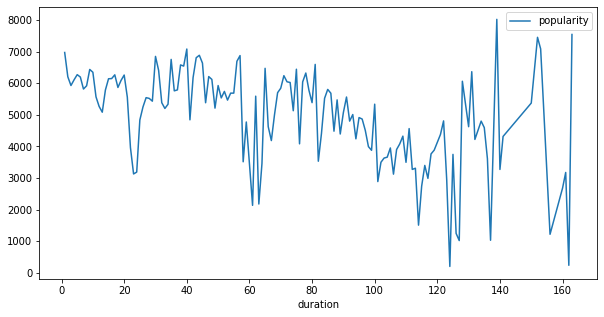

In [20]:
serije.groupby('duration').mean().plot(y='popularity')

Predvsem pri oceni uporabnikov se opazi precej višja kvaliteta pri daljših epizodah, kar je smiselno.

<AxesSubplot:xlabel='duration'>

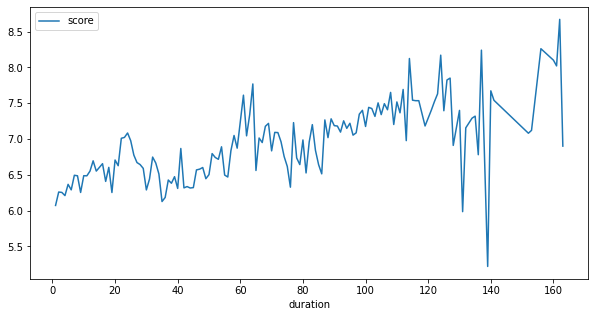

In [21]:
serije.groupby('duration').mean().plot(y='score')

## 1.4 Primernost vsebine

Primernost vsebine nakazuje katerih tem se serija dotika. Razporeditev tukaj bo bolj nakazovala porazdelitev gledajoče populacije in manj vpliv same primernosti.

In [22]:
serije.groupby('rating').mean()

,episodes,duration,score,votes,popularity,leto
rating,,,,,,
G - All Ages,16.373109,25.578097,6.556863,5351.856432,6994.969295,1998.404199
None,10.102041,32.205882,6.480648,3935.305556,5389.842593,2017.061224
PG - Children,24.597134,33.911576,6.657183,10065.247261,6282.104851,2005.676364
PG-13 - Teens 13 or older,11.789407,27.989519,6.892409,33805.883775,4275.276797,2009.077916
R - 17+ (violence & profanity),9.554252,34.699801,7.009035,67132.807992,3313.000975,2010.476615
R+ - Mild Nudity,7.428035,30.735183,6.497840,32140.171036,4174.701623,2007.871595
Rx - Hentai,2.216889,26.838627,6.268027,2264.978559,6860.121784,NaN


Opazimo precejšno razliko med popularnostjo vsebin, ciljane na najstnike in mlade odrasle, ter ali povsem odraslimi vsebinami ali pa otroškimi vsebinami. Tu res pride do izraza, kdo gleda katere serije. Največji delež gledalcev je ravno moških in to najstnikov in mladih odraslih. Zato je smiselno, da se izdaja popularne serije, ki ciljajo na ta del demografike.

<AxesSubplot:xlabel='rating'>

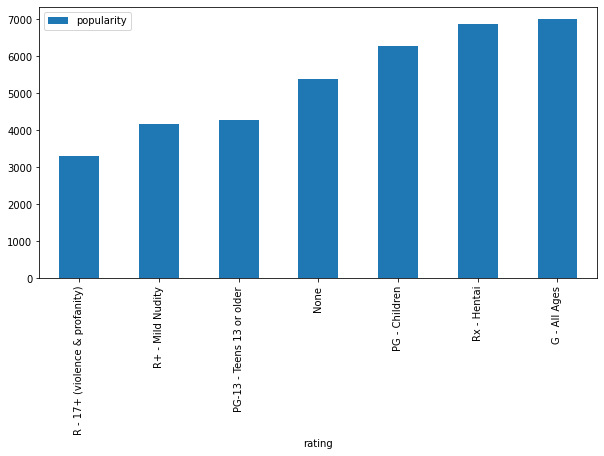

In [23]:
serije.groupby('rating').mean().sort_values('popularity').plot.bar(y='popularity')

V primerjavi s popularnostjo, pri ocenah ni tako velike razlike. Tukaj so celo dobro ocenjene manj popularne, otroške vsebine, medtem ko *R+ - Mild Nudity* pade skoraj na dno.

<AxesSubplot:xlabel='rating'>

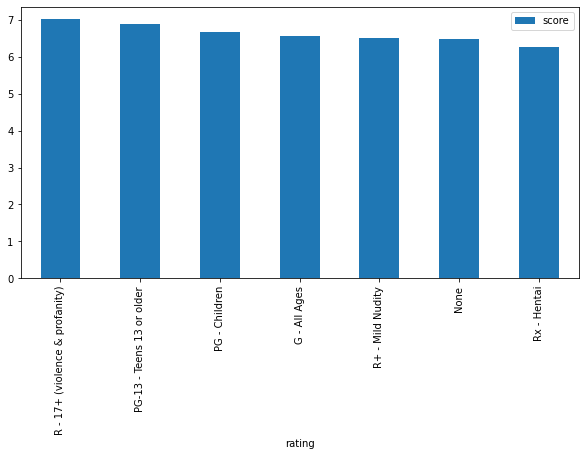

In [24]:
serije.groupby('rating').mean().sort_values('score', ascending=False).plot.bar(y='score')

## 1.5 Ocena serije

Ocena serije je povezana s popularnostjo v tem smislu, da naj bi kvaliteta serije pripomogla k njeni popularnosti. Seveda naj bi bile izjeme, kjer dobro ocenjena serija ni popularna in kjer popularne serije niso najbolje ocenjene.

In [25]:
serije.groupby('score').mean()

,episodes,duration,votes,popularity,leto
score,,,,,
1.86,1.0,19.0,14508.0,3390.0,NaN
2.04,1.0,3.0,8844.0,4426.0,NaN
2.24,1.0,19.0,34454.0,2191.0,NaN
2.31,1.0,23.0,2093.0,7142.0,NaN
2.32,1.0,NaN,2543.0,7213.0,NaN
...,...,...,...,...,...
9.08,51.0,24.0,139878.0,359.0,2011.0
9.10,110.0,26.0,47618.0,632.0,NaN
9.11,99.5,23.5,473603.0,171.0,2013.0


Opazimo, da je precej več primerov, kjer je serija popularna z nižjo oceno. To se lahko pripeti pri slabih adaptacijah v popularni franšizi. Druga možnost pa je serija, ki je na nek način stereotipična verzija trenutnega stanja. Torej vsebuje standardne tipe likov, vsebuje dostikrat uporabljeno verzijo oblike zgodbe. Take serija bo popularna, vendar pa bo slabo ocenjena, saj se ocenjevanja serij poslužijo bolj zainteresirani uporabniki, ki so morda že naveličani klišejev.

<AxesSubplot:xlabel='score', ylabel='popularity'>

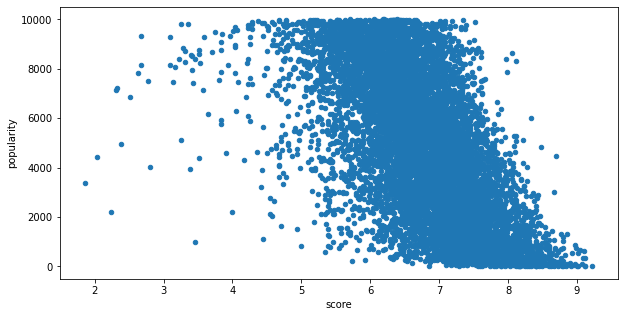

In [26]:
serije.plot.scatter(x='score', y='popularity')

## 1.6 Število glasov

Pričakovali bi, da se število glasov tesno ujema s popularnostjo. Morda so kakšne izjeme, kjer malo ljudi glasuje za dokaj priljubljeno serijo, vendar jih ne bi smelo biti veliko.

In [27]:
serije.groupby('votes').mean()

,episodes,duration,score,popularity,leto
votes,,,,,
105,1.0,97.0,6.38,8184.0,NaN
107,32.0,8.0,6.77,9266.0,NaN
108,38.5,13.0,5.73,8821.0,2016.0
109,1.0,40.0,5.54,9423.0,NaN
111,12.0,NaN,6.71,9786.0,NaN
...,...,...,...,...,...
1220469,64.0,24.0,9.22,4.0,2009.0
1283682,12.0,24.0,8.60,5.0,2015.0
1393564,25.0,23.0,7.29,3.0,2012.0


In res, boljšega prileganja se skoraj ne da dobiti. Opazimo kakšno izjemo popularne serije z malo glasovi. Lahko so to serije, ki so izšle pred kratkim in si še ni veliko ljudi ustvarilo takšnega mnenja, da bi lahko serijo ocenili. Morda pa gre za starejše popularne serije, kjer se ljudem ne zdi več potrebno podajajti svojega mnenja, saj so že tako dobro vgrajene v kulturo.

<AxesSubplot:xlabel='votes', ylabel='popularity'>

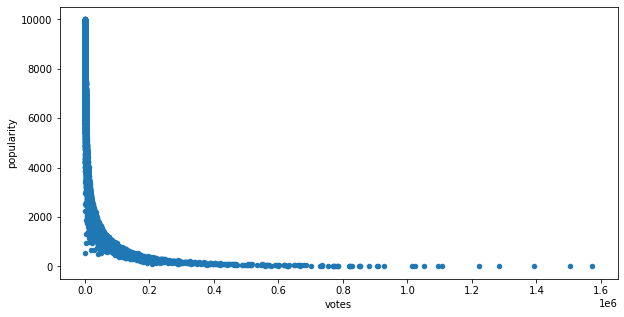

In [28]:
serije.plot.scatter(x='votes', y='popularity')

Pri vplivu na oceno pa pride do večje raznolikosti. Slabo ocenjene serije so bile bolj redko ocenjene od dobrih. Ocen, slabših od 5 sploh ni za manj kot 20.000 glasov. Pri višjem številu glasov pa je precej raznolikosti. Skupaj s prejšnim grafom sklepamo, da gre za najbolj popularne serije, kjer pa vemo, da imajo njihove ocene zmerna nihanja.

<AxesSubplot:xlabel='votes', ylabel='score'>

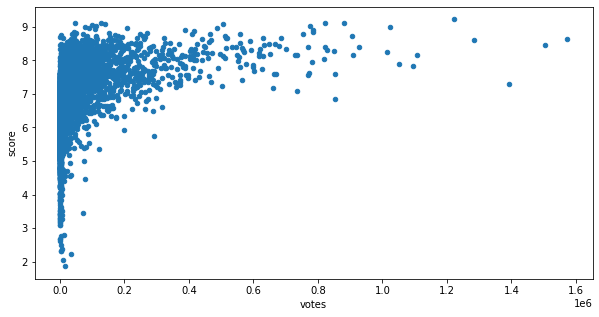

In [29]:
serije.plot.scatter(x='votes', y='score')

## 1.7 Vpletena podjetja

Podjetja imajo določeno percepcijo v očeh gledalcev. Že znano ime studija lahko prinese val zanimanja za serijo preden je sploh narejena. Prav tako pa lahko slab ugled prinese slabe ocene jeznih gledalcev, ki so po njihovem mnenju bili prikrajšani dobre dolgo pričakovane adaptacije.

Tukaj je tudi pomembno, da so nekatera podjetja vpletena v veliko večih serijah, kot ostala. Zato imajo dostikrat nižjo popularnost in nižjo oceno serij, saj jih izdajo toliko, da ne morejo biti vse dobre. Po drugi strani pa ravno njim pripadejo adaptacije najbolj popularnih serij iz drugih medijev.

Če si najprej pogledamo deset najbolj popularnih licensorjev. Recimo za *Warner Bros. Pictures*, *DreamWorks* in *Walt Disney Studios* opazimo dolgo povprečno dolžino epizod. Torej so prevzeli nase več filmov, ki so v povprečju bolje ocenjeni. Na vrhu so torej zato, ker so bili vpleteni v proizvodnji popularnih filmov.

Za večino teh podjetij je tudi res, da niso bila vpletena v veliko serijah, torej so na vrhu le zaradi dveh, treh uspešnic in niso bili vpleteni v ostalih.

In [30]:
serije_z_licensorji = pd.merge(serije, licensorji)
serije_z_licensorji.groupby('licensor').mean().sort_values('popularity')[:10]

,episodes,duration,score,votes,popularity,leto
licensor,,,,,,
Warner Bros. Pictures,26.333333,44.333333,7.350000,222951.666667,857.333333,2009.500000
feel.,1.000000,23.000000,8.110000,91704.000000,867.000000,NaN
DiC Entertainment,67.666667,24.000000,7.720000,86424.666667,897.333333,1990.333333
Pied Piper,13.000000,65.000000,8.110000,79812.500000,956.000000,2008.000000
Aniplex of America,10.021505,37.016304,7.606129,165843.677419,1060.327957,2015.098214
DreamWorks,1.000000,87.000000,8.280000,55118.000000,1141.000000,NaN
Walt Disney Studios,3.375000,102.375000,7.935625,198884.812500,1150.437500,2000.000000
Kadokawa Pictures USA,12.666667,32.666667,7.643333,165985.888889,1158.555556,2006.714286
"NIS America, Inc.",13.519231,28.653846,7.589423,117166.673077,1292.019231,2010.738095


Pri ocenah se mad najboljših deset pojavijo tudi nekateri najbolj popularni licensorji. Ponovno, tu so zaradi izdaje malega števila uspešnic in niso vpleteni v regularni proizvodnji serij.

In [31]:
serije_z_licensorji.groupby('licensor').mean().sort_values('score', ascending=False)[:10]

,episodes,duration,score,votes,popularity,leto
licensor,,,,,,
DreamWorks,1.000000,87.000000,8.280000,55118.000000,1141.000000,NaN
feel.,1.000000,23.000000,8.110000,91704.000000,867.000000,NaN
Pied Piper,13.000000,65.000000,8.110000,79812.500000,956.000000,2008.000000
Walt Disney Studios,3.375000,102.375000,7.935625,198884.812500,1150.437500,2000.000000
Eleven Arts,1.000000,96.000000,7.764545,88948.636364,2972.090909,NaN
DiC Entertainment,67.666667,24.000000,7.720000,86424.666667,897.333333,1990.333333
GKIDS,1.642857,98.243902,7.680238,97720.476190,2207.023810,2014.000000
Shout! Factory,9.444444,87.111111,7.667778,36415.000000,1874.111111,2002.500000
Kadokawa Pictures USA,12.666667,32.666667,7.643333,165985.888889,1158.555556,2006.714286


Čeprav imajo producerji velik vpliv na končen izdelek, pade večina percepcije na studije, ki so opravili animacije. Zato menimo, da nimajo direktnega vpliva na popularnost in ocene, temveč njihova razporeditev samo refleksira popularnost serij.

In [32]:
serije_s_producerji = pd.merge(serije, producerji)
serije_s_producerji.groupby('producer').mean().sort_values('popularity')[:10]

,episodes,duration,score,votes,popularity,leto
producer,,,,,,
Mad Box,25.000000,24.000000,8.450000,1505350.0,2.000000,2013.000000
12 Diary Holders,26.000000,23.000000,7.590000,852552.0,15.000000,2011.000000
Seikaisha,12.500000,26.000000,8.480000,516037.0,78.000000,2011.500000
Myrica Music,25.000000,24.000000,8.130000,348289.0,104.000000,2007.000000
C &amp; I entertainment,13.000000,23.000000,8.050000,362077.0,125.000000,2016.000000
Kamikaze Douga,24.666667,23.666667,8.246667,425682.0,131.666667,2013.666667
Micro Magazine Publishing,24.000000,23.000000,8.080000,349996.0,133.000000,2018.000000
Artist Management Office,12.000000,23.000000,7.490000,347906.0,137.000000,2018.000000
voque ting,1.000000,110.000000,8.725000,607815.0,162.500000,NaN


In [33]:
serije_s_producerji.groupby('producer').mean().sort_values('score', ascending=False)[:10]

,episodes,duration,score,votes,popularity,leto
producer,,,,,,
voque ting,1.000000,110.000000,8.725,6.078150e+05,162.500000,NaN
Miracle Robo,84.333333,26.666667,8.710,1.243177e+05,936.666667,2008.5
Annapuru,47.000000,24.000000,8.660,1.016100e+04,3002.000000,1980.0
Science SARU,11.000000,23.000000,8.630,1.153610e+05,541.000000,2014.0
FBC,24.000000,22.000000,8.540,2.915400e+04,1594.000000,2019.0
Audio Highs,101.000000,28.000000,8.525,1.165375e+05,1225.500000,2006.0
Dear Stage inc.,72.000000,14.500000,8.490,1.980210e+05,324.000000,2017.0
Seikaisha,12.500000,26.000000,8.480,5.160370e+05,78.000000,2011.5
Mad Box,25.000000,24.000000,8.450,1.505350e+06,2.000000,2013.0


Kot smo že omenili, studiji imajo velik vpliv na popularnost serij. Vsak studio ima svoj stil animacije in svojo končni izgled. Spet, tukaj prevladajo studiji z malim številom relativno uspešnih serij. Čeprav veliki studiji izdelajo najbolj popularne serije, jih izdelajo veliko vsako sezono, sicer ni smiselno imeti toliko zaposlenih. In to jim znižuje povprečje.

In [34]:
serije_s_studiji = pd.merge(serije, studiji)
serije_s_studiji.groupby('studio').mean().sort_values('popularity')[:10]

,episodes,duration,score,votes,popularity,leto
studio,,,,,,
Kadokawa,12.000000,23.000000,7.620000,117366.000000,574.000000,2020.0
Animation Do,12.333333,23.666667,7.570000,160994.333333,659.000000,2015.0
3xCube,13.000000,23.000000,6.940000,89077.000000,725.000000,2015.0
Studio Chizu,1.000000,111.333333,8.116667,171058.000000,742.000000,NaN
Egg Firm,37.750000,25.250000,8.345000,124985.750000,883.500000,2017.0
ENGI,12.000000,23.500000,6.910000,62322.500000,934.000000,2019.5
Square Enix,1.000000,109.000000,7.380000,81158.666667,1246.333333,NaN
AIC Build,7.888889,21.777778,7.117778,133602.888889,1271.222222,2011.5
Ezόla,12.000000,20.333333,7.080000,47775.000000,1278.666667,2019.0


In [35]:
serije_s_studiji.groupby('studio').mean().sort_values('score', ascending=False)[:10]

,episodes,duration,score,votes,popularity,leto
studio,,,,,,
Egg Firm,37.7500,25.250000,8.345000,124985.7500,883.5000,2017.000000
Colored-Pencil Animation Design,12.0000,26.000000,8.220000,3636.0000,1895.0000,NaN
Studio Chizu,1.0000,111.333333,8.116667,171058.0000,742.0000,NaN
Samsara Animation Studio,3.0000,28.000000,8.010000,2855.0000,4299.0000,NaN
Nippon Ramayana Film Co.,1.0000,135.000000,7.980000,1490.0000,7859.0000,NaN
Djinn Power,10.0000,20.000000,7.840000,576.0000,6643.0000,NaN
Purple Cow Studio Japan,2.5000,52.500000,7.735000,54046.0000,1926.0000,NaN
Code,26.0000,23.000000,7.720000,3754.0000,4341.0000,2009.000000
Shuka,6.1875,27.187500,7.708750,55776.4375,2205.4375,2016.428571


## 1.7 Žanr serije

Žanr serije je povezan s popularnostjo v tem smislu, da različne dele populacije zanimajo različne stvari. Torej med popularnimi žanri pričakujemo teme, ki so blizu najstnikom in mlajšim odraslim.

Je pa tukaj tudi možno, da bodo na vrhu bolj specializirani in usmerjeni žanri, saj bo adaptiran le dober originalni material, medtem ko za žanre, kjer bi pričakovali širše zanimanje, jim bodo popularnost zniževalo veliko število sprejemljivih, a ne odličnih serij.

Do neke mere se to res opazi. Akcijske serije, komedije, fantazije npr. niso proti vrhu. Tam so psihološke, vampirske serije, trilerji. Se pa najdejo na vrhu tudi haremske in shojo serije. (namenjene najstnicam, tj. romantične in emocionalne vsebine)

Bolj zahodnjaški žanri so proti dnu. Različne avtomobilske, športne, znanstveno-fantastične serije niso priljubljene na Japonskem in zato ni dobrega originalnega materiala, po katerem bi bilo veliko izvedenih priljubljenih serij.

<AxesSubplot:xlabel='genre'>

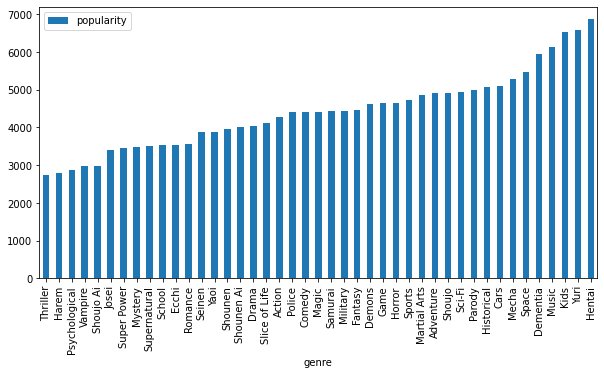

In [36]:
serije_z_zanri = pd.merge(serije, zanri)
serije_z_zanri.groupby('genre').mean().sort_values('popularity').plot.bar(y='popularity')

<AxesSubplot:xlabel='genre'>

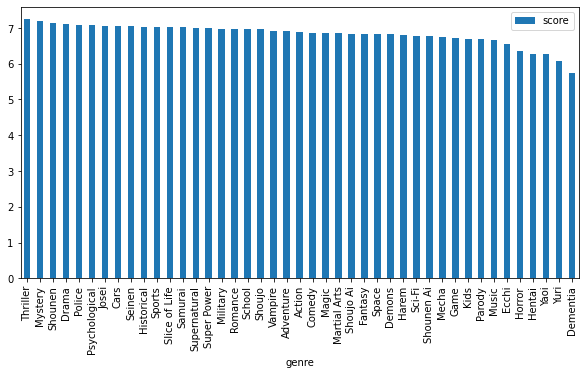

In [37]:
serije_z_zanri.groupby('genre').mean().sort_values('score', ascending=False).plot.bar(y='score')